# AWS MLE Practice Exam Questions: A Practical Walkthrough

These focus areas are the questions I got incorrect on my latest practice exam attempt. This notebook serves as a hands-on study guide for the AWS Machine Learning Engineer Associate exam. It covers several key concepts identified from practice questions, demonstrating them using Python libraries without directly invoking AWS services. The goal is to understand the underlying principles, which can then be mapped to corresponding AWS tools like SageMaker.

We will follow a narrative simulating parts of an ML project lifecycle:
1.  **Data Preparation:** Addressing class imbalance.
2.  **Feature Management:** Conceptualizing a feature store workflow.
3.  **Modeling:** Choosing appropriate algorithms (XGBoost for classification, RCF-like for anomaly detection), implementing ensembles (Stacking), and preventing overfitting.
4.  **Evaluation & Explainability:** Understanding model predictions (SHAP vs. PDP) and detecting bias (CDD).
5.  **MLOps & Lifecycle:** Conceptualizing pipelines, lineage tracking, and model registries.
6.  **Model Improvement:** Strategies like feature engineering and debugging.

In [1]:
pip install pandas scikit-learn xgboost shap imbalanced-learn matplotlib seaborn

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   -- ------------------------------------- 8.4/150.0 MB 47.2 MB/s eta 0:00:03
   ---- ----------------------------------- 16.8/150.0 MB 44.0 MB/s eta 0:00:04
   ------ --------------------------------- 25.4/150.0 MB 43.5 MB/s eta 0:00:03
   ------- -------------------------------- 29.1/150.0 MB 38.4 MB/s eta 0:00:04
   ---------- ----------------------------- 38.0/150.0 MB 39.0 MB/s eta 0:00:03
   ------------ --------------------------- 46.9/150.0 MB 39.8 MB/s eta 0:00:03
   -------------- ------------------------- 55.8/150.0 MB 40.4 MB/s eta 0:00:03
   ----------------- ---------------------- 65.3/150.0 MB 40.8 MB/s eta 0:00:03
   ------------------- -------------------- 73.1/150.0 MB 40.6 MB/s eta 0:00:02
   --------------------- ------------------ 82.3/150.0 MB 41.3 MB/s eta 0:00:02
   ------------------------ --------------- 91.5/150.0 MB 41.7 MB/s eta 0:00:02
   -------------------------- ------------ 101.4/1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import RandomOverSampler # Using imblearn for simplicity
import xgboost as xgb
import shap
import time # For early stopping simulation
from IPython.display import display # To display SHAP plots correctly in VS Code notebooks

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


c:\Users\phili\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation: Handling Class Imbalance (Q50)

**Concept:** Real-world datasets, especially in areas like fraud detection or rare disease prediction, often suffer from class imbalance (one class is much rarer than others). Standard algorithms can become biased towards the majority class. Techniques like oversampling (duplicating minority samples) or undersampling (removing majority samples) are used to create a balanced dataset for training.

**Relation to Practice Question:** I incorrectly identified AWS Glue DataBrew as the primary tool for balancing. While DataBrew is great for general data cleaning, **Amazon SageMaker Data Wrangler** provides specific, built-in transformations like 'Balance Data' (using over/under-sampling techniques like SMOTE or simple duplication) with a user-friendly interface, minimizing operational effort for this specific task. AWS Glue ETL would require custom scripting.

**ML Domain:** Data Preparation for Machine Learning (ML)

**Why it Matters:** Failing to address imbalance can lead to models that perform poorly on the minority class, which is often the class of interest (e.g., detecting fraud).

**AWS Tool:** Amazon SageMaker Data Wrangler (specifically its 'Balance Data' transform).

Original dataset shape: (1000, 20)
Original class distribution:
 target
0    0.95
1    0.05
Name: proportion, dtype: float64


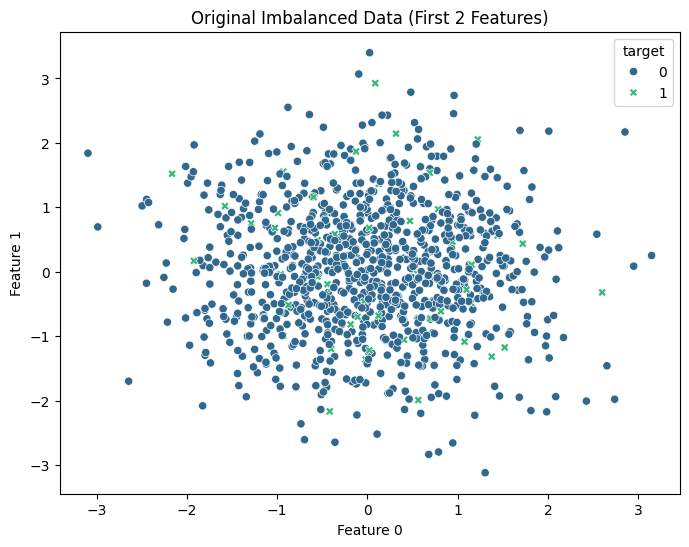


Resampled dataset shape: (1900, 20)
Resampled class distribution:
 target
0    0.5
1    0.5
Name: proportion, dtype: float64


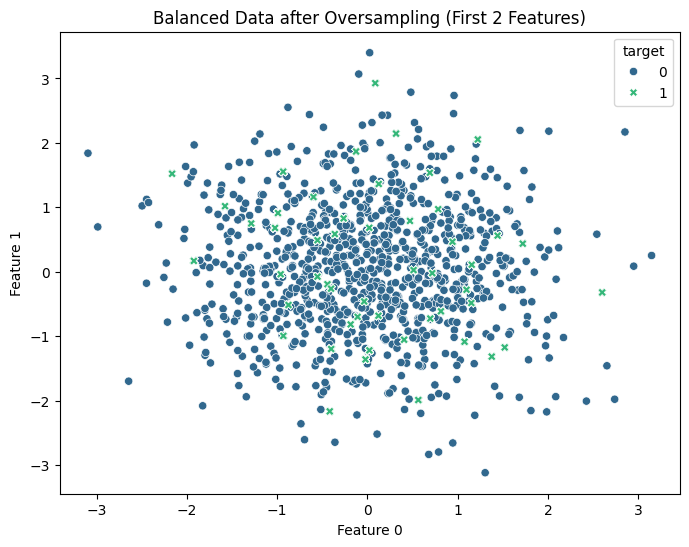


Train set shape: (1520, 20)
Test set shape: (380, 20)
Imbalanced Test set shape: (200, 20)


In [4]:
# --- Generate Imbalanced Data ---
X, y = make_classification(n_samples=1000, n_features=20, n_informative=5,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.95, 0.05], flip_y=0, random_state=42) # 95% class 0, 5% class 1

X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
y = pd.Series(y, name='target')

print("Original dataset shape:", X.shape)
print("Original class distribution:\n", y.value_counts(normalize=True))

# --- Visualize Imbalance (using first 2 features for simplicity) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, style=y, palette='viridis')
plt.title('Original Imbalanced Data (First 2 Features)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

# --- Apply Oversampling (using RandomOverSampler) ---
# This simulates what SageMaker Data Wrangler's "Balance Data" (oversampling) might do.
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("\nResampled dataset shape:", X_resampled.shape)
print("Resampled class distribution:\n", y_resampled.value_counts(normalize=True))

# --- Visualize Balanced Data ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_resampled.iloc[:, 0], y=X_resampled.iloc[:, 1], hue=y_resampled, style=y_resampled, palette='viridis')
plt.title('Balanced Data after Oversampling (First 2 Features)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

# --- Split data for later use ---
# We'll use the balanced data for most subsequent steps
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# --- Also keep original imbalanced test set for realistic evaluation ---
# Create an imbalanced test set from the *original* data
_, X_test_imb, _, y_test_imb = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("\nTrain set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Imbalanced Test set shape:", X_test_imb.shape)